# IMDB dataset importing

In [1]:
# Libraries importing
from keras.datasets import imdb
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 4000)
# num_words = dictionnary len

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# 0 = pad token
# 1 = beginning character of the review
# 2 = words that aren't in the dictionnary : "oov_char" parameter

# Dataset processing

In [4]:
# Definition of the review structure in 200 characters
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 200)
x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = 200)

In [5]:
x_train_padded.shape, x_test_padded.shape

((25000, 200), (25000, 200))

In [6]:
# Defining validation and test data
x_data_val, y_data_val = x_test_padded[:int(len(x_test_padded)/2)], y_test[:int(len(x_test_padded)/2)]
x_data_test, y_data_test = x_test_padded[int(len(x_test_padded)/2):], y_test[int(len(x_test_padded)/2):]

In [7]:
x_data_val.shape, x_data_test.shape

((12500, 200), (12500, 200))

# Definition of the model

In [8]:
# Libraries importing
from keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Flatten
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

In [42]:
token_projection_dim = 64

input_layer = Input(shape = [200,], dtype = 'int64')

embedding_layer = Embedding(input_dim = 4000, input_length = 200, output_dim = token_projection_dim)(input_layer)

MHA_layer = MultiHeadAttention(num_heads = 2, dropout = 0.1, key_dim = token_projection_dim)(embedding_layer, embedding_layer, embedding_layer)

normalization_layer1 = LayerNormalization(epsilon = 1e-6)(embedding_layer + MHA_layer)

dense_layer1 = Dense(token_projection_dim, activation = "tanh")(normalization_layer1)

dense_layer2 = Dense(token_projection_dim, activation = "tanh")(dense_layer1)

normalization_layer2 = LayerNormalization(epsilon = 1e-6)(normalization_layer1 + dense_layer2)

flatten_layer = Flatten()(normalization_layer2)

output_layer = Dense(1, activation = "sigmoid")(flatten_layer)

model = Model(inputs = input_layer, outputs = output_layer)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = BinaryCrossentropy(), metrics = [BinaryAccuracy()])

# Model fitting
history = model.fit(x_train_padded, y_train, batch_size = 32, epochs = 5, validation_data = (x_data_val, y_data_val))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - binary_accuracy: 0.6415 - loss: 0.7111 - val_binary_accuracy: 0.8202 - val_loss: 0.4141
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - binary_accuracy: 0.9231 - loss: 0.1929 - val_binary_accuracy: 0.8441 - val_loss: 0.3999
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - binary_accuracy: 0.9821 - loss: 0.0552 - val_binary_accuracy: 0.8424 - val_loss: 0.5027
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - binary_accuracy: 0.9952 - loss: 0.0188 - val_binary_accuracy: 0.8460 - val_loss: 0.5754
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - binary_accuracy: 0.9993 - loss: 0.0055 - val_binary_accuracy: 0.8422 - val_loss: 0.6557


In [31]:
plot_model(model, to_file = "Transformers_model.png", show_shapes = True);

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


# Displaying the training results

In [32]:
# Libraries importing
import pandas as pd

In [33]:
df_curve = pd.DataFrame(history.history)
df_curve_loss = df_curve[["loss", "val_loss"]]
df_curve_acc = df_curve[["binary_accuracy", "val_binary_accuracy"]]

<Axes: >

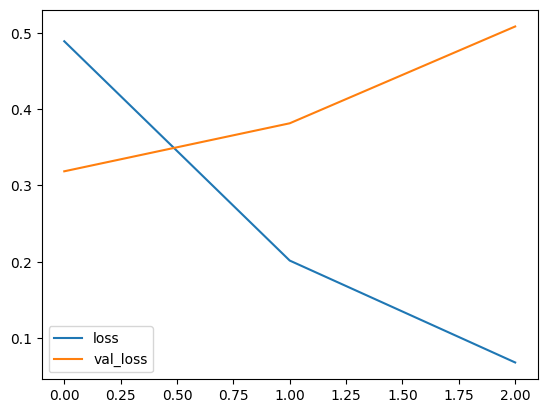

In [34]:
df_curve_loss.plot()

<Axes: >

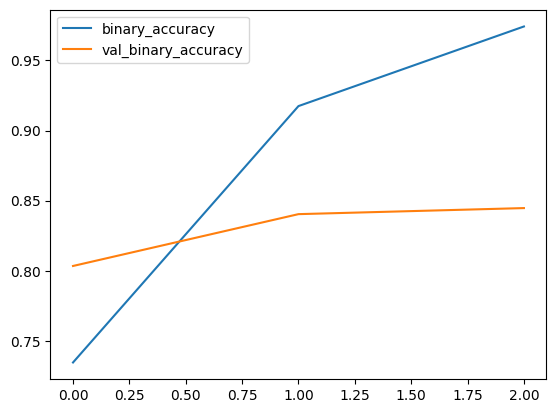

In [14]:
df_curve_acc.plot()

# Testing the model with test data

In [15]:
model.evaluate(x_data_test, y_data_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.8510 - loss: 0.4451


[0.44648686051368713, 0.852400004863739]

# Prediction with test data

In [16]:
import numpy as np

In [17]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def review_decoder(encoded_reviews) :
    decoded_reviews = encoded_reviews.copy()
    for i in range (len(encoded_reviews)) :
        decoded_reviews[i] = " ".join([reverse_word_index.get(j - 3, '') for j in decoded_reviews[i]])
    return decoded_reviews

In [18]:
x_test_decoded = review_decoder(x_test)

In [19]:
review_index = 1030

In [20]:
x_test_decoded[review_index]

" the movie was slow the dialogue between actors actresses felt flat and basically there was no development of the characters in the story br br    around with a mad look on his face the entire time  and basically looking annoyed with everybody  has no on screen magic and  character is a that nobody would want to hang out with even if they were paid to do so br br throw in the weird scene where  has to dance with an old man and you have what quite possibly could be the worst movie in cinema history br br i watched it on  thank  i didn't pay for it and  i hadn't br br do yourself a favor and go sort your  and   if you need something to do but are  to watch this movie when if it comes on your tv awful movie if you ask me and i generally have something good to say about just about any movie out there"

In [21]:
model.predict(x_test_padded[review_index : review_index + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


array([[1.6477326e-05]], dtype=float32)

In [22]:
y_test[review_index]

0